<a href="https://colab.research.google.com/github/bingsen-wang/Electric-Machines/blob/main/ElectricMachines_HybridStepperMotor_3pole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Hybrid Stepper Motor: 3 Rotor Poles</h1></b>

Dr. Bingsen Wang

8/11/2024
</center>

#Python Code
The Python code illustrates a hybrid stepping motor.

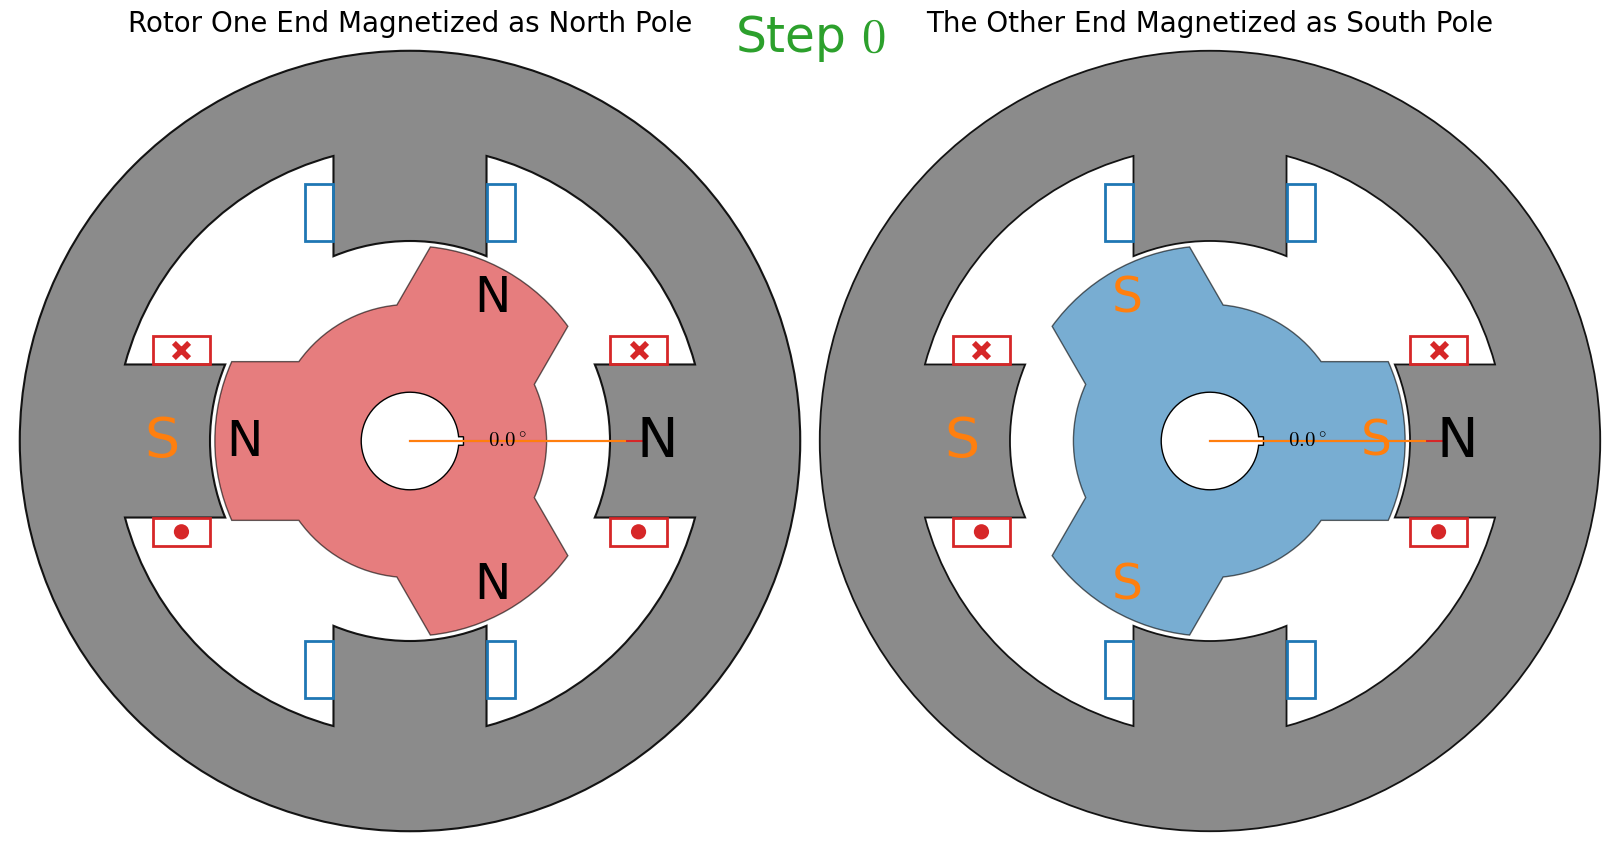

In [31]:
from os import linesep
import numpy as np
from numpy import linspace,cos,sin,pi,exp,angle,array,sqrt,arcsin,arccos,conj
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib.path import Path
from matplotlib.patches import PathPatch,Arc,Circle
from matplotlib import animation,transforms,colors
plt.rcParams.update({"font.family" : "sans serif","mathtext.fontset" : "cm"})

def axis_reset(ax): #clear axis for redrawing
  xy=ax.axis(); ax.cla(); ax.axis('off'); ax.set(xlim=xy[:2],ylim=xy[-2:])
  return
def re_im(c):
  return list(zip(c.real,c.imag))
def r2d(rad):
  return rad*180/pi
def d2r(deg):
  return deg*pi/180

def draw_rotor(ax,ro,ri,ns,fc='w',ec='k',lw=1,alpha=1,theta=0,theta_key=0,pole_name='N'): #straight teeth, round slot bottom
  """ro: outer radius;  ri: inner radius; ns: number of slots
  nsp: number of slots to plot"""
  tts = 2*pi/ns #tooth spacing in rad
  tso,ds = tts*.6, (ro-ri)*.4 #slot span at ro in rad, slot depth
  tsp,tsi = tso,tts-2*arcsin(ro*sin(.5*(tts-tso))/(ro-ds)) #slot opening, slot bottom angle span
  dt = 2*ro*sin(.5*(tts-tso)) #tooth thickness
  v,c=[],[]
  for k in range(ns):
    aci = Path.arc(r2d(tts*k-.5*tsi),r2d(tts*k+.5*tsi)) #inner arc
    aco = Path.arc(r2d(tts*k+.5*tsp),r2d(tts*(k+1)-.5*tsp)) #outer arc
    v += list(aci.vertices*(ro-ds)) + list(aco.vertices*ro)
    c += [Path.LINETO]+list(aci.codes[1:]) + [Path.LINETO] + list(aco.codes[1:])
    tr = transforms.Affine2D().rotate(theta+(k+.5)*tts)+ax.transData
    ax.text(ro-.5*ds,0,pole_name,size=35,transform=tr,ha='center',va='center',
            c=clst[-2] if pole_name=='N' else clst[3]) #pole name at teeth
  tr = transforms.Affine2D().rotate(theta)+ax.transData
  p = Path(v+[[0,0]],[Path.MOVETO]+c[1:]+[Path.CLOSEPOLY]) #rotor ourter shape
  ax.add_patch(PathPatch(p,ec=ec,fc=fc,alpha=alpha,lw=lw,transform=tr))

  tr = transforms.Affine2D().rotate(theta+theta_key)+ax.transData
  xy_key = array([exp(-1j*d2r(5))*ri+ri*.1,exp(1j*d2r(5))*ri+ri*.1]) # +/- 5 degrees for keyway
  p=Path(list(Path.arc(5,355).vertices*ri) + re_im(xy_key)+[[0,0]],
         list(Path.arc(5,355).codes)+[Path.LINETO]*2+[Path.CLOSEPOLY])
  ax.add_patch(PathPatch(p,ec=ec,fc='w',lw=lw,transform=tr)) #rotor inner

  #rotor angle reference marking
  ax.plot([0,ro*1.2],[0,0],c=clst[0]) #ref line
  ax.plot([0,ro*1.1],[0,0],c=clst[3],transform=tr) #rotor axis
  ax.add_patch(mp.Arc((0,0),ro*.8,ro*.8,theta2=r2d(theta+theta_key)))
  tr = transforms.Affine2D().rotate(.5*(theta+theta_key))+ax.transData
  ax.text(ro*.5,0,r'${:.1f}^\circ$'.format(r2d(theta+theta_key)),size=15,
          ha='center',va='center',transform=tr)

  return

def draw_stator(ax,ro,ri,ns,clst,fc='w',ec='k',lw=1,alpha=1,theta=0):
  ax.add_patch(mp.Circle((0,0),ro,lw=lw,fc=fc,ec=ec,alpha=alpha))
  tts = 2*pi/ns #tooth spacing in rad
  tsi,ds  = tts*.5, (ro-ri)*.5 #slot span at ri in rad, slot depth
  tsp,tso = tsi,tts-2*arcsin(ri*sin(.5*(tts-tsi))/(ri+ds)) #slot opening, slot bottom angle span
  dt = 2*ri*sin(.5*(tts-tsi)) #tooth thickness
  xy = [exp(-1j*tsp*.5)*ri+.3*dt,exp(-1j*tsi*.5)*ri+.5*dt*exp(-1j*tts/2),exp(-1j*tso/2)*(ri+ds)]
  pts0 = np.array(xy+list(conj(xy[::-1]))) #[xy,xy's reverse conjugate]
  npt = 5 #number of pole teeth
  tpt = (tts-tsp)/(npt-.5) #tooth spacing of pole teeth
  tpso = .5*tpt #pole slot opening
  dps = 0.15*dt #pole slot depth
  v,c=[],[] #vertices and codes
  #stator shape
  for k in range(ns):
    aco = Path.arc(r2d(tts*k-.5*tso),r2d(tts*k+.5*tso)) #outter arc
    aci = Path.arc(r2d(tts*k+.5*tsp),r2d(tts*(k+1)-.5*tsp)) #inner arc
    v += list(aco.vertices*(ri+ds))+list(aci.vertices*ri)
    c += [Path.LINETO] + list(aco.codes[1:])+[Path.LINETO] + list(aci.codes[1:])
  tr = transforms.Affine2D().rotate(theta)+ax.transData
  p = Path(v+[[0,0]],[Path.MOVETO]+c[1:]+[Path.CLOSEPOLY])
  ax.add_patch(PathPatch(p,ec=colors.to_rgba(ec,alpha),fc='w',lw=lw,transform=tr))
  return

def draw_stator_conductors(ax,ro,ri,ns,clst,fc='w',ec='k',lw=1,alpha=1,theta=0,iabc=[0,0,1],phase=0):
  tts = 2*pi/ns #tooth spacing in rad
  tsi,ds  = tts*.5, (ro-ri)*.5 #slot span at ri in rad, slot depth
  dt = 2*ri*sin(.5*(tts-tsi)) #tooth thickness
  #conductors and polarities
  for k in range(ns):
    tr = transforms.Affine2D().rotate(theta+k*tts+pi/ns)+ax.transData
    for kk in range(2):
      ax.add_patch(mp.Rectangle((ri,dt*.5-(dt+.3*ds)*kk),.6*ds,.3*ds,lw=2,fc='none',ec=clst[k%2],zorder=2,transform=tr))
  for k in range(len(iabc)):
    for kk in range(2):
      y = dt*.5+.15*ds-(dt+.3*ds)*(kk%2)
      tr = transforms.Affine2D().rotate(kk*pi+(k+.5)*tts+theta+(iabc[k]-1)*pi/2)+ax.transData
      ax.text(ri+ds/2,0,['N','S'][kk%2],size=40*abs(iabc[k]),transform=tr,
              color=[clst[-2],clst[3]][kk%2],va='center',ha='center')
      ax.add_patch(mp.Circle((ri+.3*ds,-y),.08*ds*abs(iabc[k]),lw=lw,ec='none',fc=clst[k],zorder=2,transform=tr))
      ax.scatter(ri+.3*ds,y,s=120*abs(iabc[k]),marker='x',c=clst[k],lw=4,transform=tr)
  return

#parameters
Nfps = 12 #number of frames
Nst,Nrt = 4,3 #number of stator teeth, rotor teeth
rso,rro = 4,2 #stator outer radius, rotor outer radius
rsi,rri = 2.05,.5 #stator inner radius, rotor inner radius
f=1
t=linspace(0,1/f*(Nfps-1)/Nfps,Nfps) #time
i_ser = [[1,0],[0,-1],[-1,0],[0,1]] #switching logic

xylim = [[-4.1,4.1] for _ in range(2)]
clst=['tab:red','tab:blue','tab:brown','tab:orange','tab:pink','tab:olive','tab:grey','tab:green','k','w'] #colors light bg
fig = plt.figure(figsize=(16,9))
axs=[]
for k in range(4):
  axs.append(fig.add_axes((k%2/2,1/36,1/2,8/9),xlim=xylim[0],ylim=xylim[1],fc='none'))
  axs[k].axis('off')

for k in range(2):
  draw_stator(axs[k],rso,rsi,Nst,clst,fc=clst[-4],alpha=.9,lw=1.5-k*.2,theta=-pi/Nst)
  axs[k].text(0,4.2,'{} Magnetized as {} Pole'.format(['Rotor One End', 'The Other End'][k],['North','South'][k]),size=20,ha='center')
txt_step =axs[0].text(4.1,4,'',size=35,ha='center',c=clst[-3])

def animate(i): # animation function. This is called sequentially
  # i=4
  txt_step.set_text('Step ${}$'.format(i)) #current step
  for k in range(2):
    axis_reset(axs[k+2]) #clear axis
    draw_stator_conductors(axs[k+2],rso,rsi,Nst,clst,fc=clst[-4],alpha=.7,lw=1.5-k*.2,iabc=i_ser[i%4],phase=k,theta=-pi/Nst)
    draw_rotor(axs[k+2],rro,rri,Nrt,fc=clst[k],alpha=.6,lw=1,theta=2*pi*f*t[i]-pi/Nrt*k,theta_key=pi/Nrt*k,pole_name=['N','S'][k])
  fig.savefig('{}.png'.format(i),dpi=300) #save figure for each step
  return
anim = animation.FuncAnimation(fig, animate, frames=Nfps)
anim.save("ElectricMachine_HybridStepper_3pole.mp4", writer=animation.FFMpegWriter(fps=.5),dpi = 200)